## Short description of the notebook

This notebook was created and ran in google colab.

This is an amendment to the main notebook. For further documantion, one shall see the main notebook.

In this notebook, the problem is solved with only *convolutional* and *dense* NN layers (without *locally connected layers*) to prove the necessity of a *locally connected layer*. 

## Importing the necessary libraries

In [1]:
# Basic calculations and plotting 
import numpy as np
import matplotlib.pyplot as plt

# Generating random numbers
import random

# Prerocessing the data, splitting the dataset, calculating the accuracy
from sklearn import preprocessing
import skimage.measure
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Creating the NN
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Permute, Dense, Activation, LocallyConnected2D, Reshape, Flatten, Dropout, Input, Conv2D
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.optimizers

## Loading and preprocessing the data

In [2]:
# Importing the dataset

x_all = np.genfromtxt("interp_scattered_Noisy_NearFieldData.txt", delimiter='')
y = np.genfromtxt("Characteristics_no_rep.txt", delimiter='')

# Setting the number of angles

number_of_angles = 16

# We can delete the last column of the imported dataset, cause we don't calculate with the wavelength just yet

y = np.delete(y, [4], axis = 1)

# We transform the y-coordinates, so the norm is one

y = y+3
y = y/6

In [3]:
# Creating some lists to store the new datasets

dataset = []
reduced_dataset = []

# Separating the dataset into list of lists
# Preprocessing the dataset with the preprocessing.scale() function

for i in range(0,number_of_angles):
    dataset.append(preprocessing.scale(x_all[735*(i):735*(i+1)], axis=0))

# Reducing the size of the dataset with the skimage.measure.block_reduce() function
# Reducing the size of vectors from len = 161 to len = 11
# For this the splitting size must equal to 15
# Using np.average to estimate between the points

splitting_size = 15

for i in range(0,len(dataset)):
    reduced_dataset.append(skimage.measure.block_reduce(dataset[i], (1,splitting_size), np.average))

In [4]:
# Splitting the matrix to train and test dataset
# Creating some lists to store the data
# Saving the train and test datasets to lists

def dataset_split(reduced_dataset, rand_state):

    combined_vector_train = []
    combined_vector_test = []

    for i in range(0,len(reduced_dataset)):
        x_train, x_test, y_train, y_test = train_test_split(reduced_dataset[i], y, test_size = 0.08, random_state = rand_state) 

        combined_vector_train.append(x_train)
        combined_vector_test.append(x_test)

    # Changing the dimensions of the matrices, so they are appropriate for the NN

    combined_vector_train = np.swapaxes(combined_vector_train,0,1)
    combined_vector_test = np.swapaxes(combined_vector_test,0,1)

    matrix_of_results = [combined_vector_train, combined_vector_test, y_train, y_test]

    return(matrix_of_results)

## Creating the model and launching the neural network

Run 1 / 1


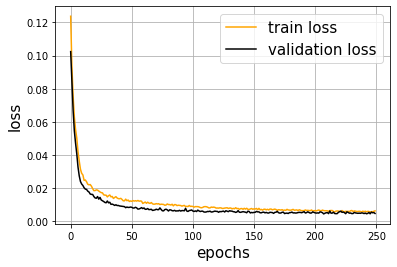

The accuracy of the model:  0.8347
Validation loss = 0.0047
Minimum of validation loss: 0.0044 at EPOCH 207



In [5]:
# Setting the parameters of the NN

runs = 1
BATCH = 32
EPOCH = 250

acc_scores = []
val_loss_scores = []


for i in range (0,runs):

    # Generating a random number and using it as the random_state of the train-test splitting
    random_state = random.randint(0,100)
    # Calling the function of the splitting 
    results = dataset_split(reduced_dataset, random_state)

    # Saving the results in arrays
    combined_vector_train = results[0]
    combined_vector_test = results[1]
    y_train = results[2]
    y_test = results[3]

    # Creating the model
    model = Sequential()

    # Adding the layers
    model.add(Permute((2,1), input_shape=(16,11)))
    model.add(Reshape((16,11,1)))
    model.add(Conv2D(2,3, activation='relu', use_bias=True))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Flatten())
    model.add(Dense(4,activation='sigmoid'))
    
    # Setting the optimizer and compiling the model
    optimizer = keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.8, amsgrad=False)
    model.compile(loss='mse', optimizer=optimizer)
    
    # Fitting the model
    print("Run",i+1,"/",runs)
    history = model.fit(combined_vector_train, y_train, validation_data=(combined_vector_test, y_test), batch_size=BATCH, epochs=EPOCH, verbose = 0)
    
    # Calculating the different parameters of the model
    min_of_val_loss = np.min(history.history['val_loss'])
    index_of_min = history.history['val_loss'].index(min_of_val_loss)
    val_loss_min = '{:0.4f}'.format(min_of_val_loss)
    val_loss_final = '{:0.4f}'.format(history.history['val_loss'][EPOCH-1])
    
    # Plotting the validation- and training loss of the model
    plt.plot(history.history['loss'], color = 'orange', label='train loss')
    plt.plot(history.history['val_loss'], color = 'black', label='validation loss')
    plt.xlabel('epochs', fontsize=15)
    #plt.ylim(0, 0.006)
    plt.ylabel('loss', fontsize=15)
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

    # Predicting the test values of the dataset
    predicted_values = np.matrix.round(model.predict(combined_vector_test)*6-3)
    y_test_pred_flat = np.ndarray.flatten(predicted_values)
    y_test_flat = np.ndarray.flatten(y_test)

    # Calculating the accuracy of the model
    acc = accuracy_score(y_test_flat*6-3, y_test_pred_flat)
    
    # Printing the results
    print('The accuracy of the model: ', round(acc,4))
    print("Validation loss =", '{:0.4f}'.format(history.history['val_loss'][EPOCH-1]))
    print('Minimum of validation loss:', '{:0.4f}'.format(min_of_val_loss), 'at EPOCH', index_of_min)
    print()

    acc_scores.append(round(acc,3))
    val_loss_scores.append(round(history.history['val_loss'][EPOCH-1],4))
